# **Lista 5 de Processamento de Imagens**

Professora: Mylene Farias

Aluna: Daniele Dias

matrícula: 20/0081691

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
# Check current working directory.
print(os.getcwd())
os.chdir('/content/drive/MyDrive/processamento_imagens/Lista 05')
# Check current working directory.
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/MyDrive/processamento_imagens/Lista 05


#Global

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import itertools
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils    


################################################################################
############################## my functions  ###################################
################################################################################

################################ item 1 ########################################
def circles(image,n, param_2):
  img = cv2.medianBlur(image,11)
  img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (n, n)))
  cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

  circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=100,param2=param_2,minRadius=0,maxRadius=0)

  circles = np.uint16(np.around(circles))
  for i in circles[0,:]:
      # draw the outer circle
      cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
      # draw the center of the circle
      cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
  return cimg, circles

################################ item 2 ########################################

def jpeg_implementation(img, quality):
  # Adaptaded by Birendra Bikram Singh, Jpeg Compression
  # https://www.mathworks.com/matlabcentral/fileexchange/38518-jpeg-compression
  row, coln = img.shape
  img = img.astype(float)

  #Quality Matrix Formulation
  Q50 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
               [12, 12, 14, 19, 26, 58, 60, 55],
               [14, 13, 16, 24, 40, 57, 69, 56],
               [14, 17, 22, 29, 51, 87, 80, 62],
               [18, 22, 37, 56, 68, 109, 103, 77],
               [24, 35, 55, 64, 81, 104, 113, 92],
               [49, 64, 78, 87, 103, 121, 120, 101],
               [72, 92, 95, 98, 112, 100, 103, 99]])
  if quality < 50:
    QX = np.round(Q50*((100-quality)/50)).astype(float)
  elif quality >= 50:
    QX = np.round(Q50*(50/quality)).astype(float)
  #print(QX)
  #----------------------------------------------------------
  # Jpeg Compression
  #----------------------------------------------------------
  dct_restored = np.zeros((row,coln))
  dct_domain = np.zeros((row,coln))
  dct_quantized = np.zeros((row,coln))
  dct_dequantized = np.zeros((row,coln))


  #Forward Discret Cosine Transform
  for i in range(0,row, 8):
    for j in range(0,coln, 8):
      dct_domain[i:i+8,j:j+8] = cv2.dct(img[i:i+8,j:j+8])/8


  for i in range(0,row, 8):
    for j in range(0,coln, 8):
      if QX.size == dct_domain[i:i+8,j:j+8].size:
        dct_quantized[i:i+8,j:j+8] = np.round(dct_domain[i:i+8,j:j+8]/QX)
  
  for i in range(0,row, 8):
    for j in range(0,coln, 8):
      if QX.size == dct_domain[i:i+8,j:j+8].size:
        dct_dequantized[i:i+8,j:j+8] = np.round(dct_quantized[i:i+8,j:j+8]*QX)

  for i in range(0,row, 8):
    for j in range(0,coln, 8):
      dct_restored[i:i+8,j:j+8] = np.round(cv2.idct(dct_dequantized[i:i+8,j:j+8])*8)
  return dct_domain, dct_quantized, dct_dequantized, dct_restored

def calculate_psnr(img1, img2):
  # img1 and img2 have range [0, 255]
  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  mse = np.mean((img1 - img2)**2)
  if mse == 0:
    return float('inf')
  return 20 * math.log10(255.0 / math.sqrt(mse))

def metrics(img, dct_restored):
  pnsr =calculate_psnr(img, dct_restored)
  mse = mean_squared_error(img, dct_restored)
  ssim_const = ssim(img, dct_restored,
                  data_range=dct_restored.max() - dct_restored.min())
  return pnsr, mse, ssim_const

def entropy(img):
  nj = (img - img.min()) * 255
  N = img.max() - img.min()
  #Output
  img = nj / N
  row,coln = img.shape
  hist1, bins1 = np.histogram(img, 256, [0,256])
  prob = np.zeros((len(hist1)))
  for i in range(len(hist1)):
    prob[i]= hist1[i]/(row*coln)
    if prob[i] != 0:
      H = -np.sum(prob[i]*(math.log2(prob[i])))
  return H

################################ item 3 ########################################
def get_centroid(binary_image):
  N_ones = binary_image.sum()
  x = 0
  y = 0
  row, coln = binary_image.shape

  for i in range(row):
    for j in range(coln):
      if binary_image[i, j]:
        x += j
        y += i
  total_x = int(x / N_ones) 
  total_y = int(y / N_ones)
  return total_x, total_y
# %%
def r_theta(image):
  binary_image = np.round(image / 255).astype(bool)
  row, coln = image.shape
  x0, y0 = get_centroid(binary_image)
  centroid = np.array((x0, y0))
  angles = np.linspace(0, 360, 360, endpoint=False)
  distance = np.zeros_like(angles)
  for i, j in enumerate(angles):
    rad = np.deg2rad(j)
    ds = np.arange(np.min((row, coln)))
    xs = (x0 + ds * np.cos(rad)).astype(int)
    ys = (y0 + ds * np.sin(rad)).astype(int)
    val = (xs >= 0) & (xs < row) & (ys >= 0) & (ys < coln)
    xs = xs[val]
    ys = ys[val]
    coords = np.stack((ys, xs), axis=-1)
    coords = np.unique(coords, axis=0)
    coord = centroid
    for c in coords:
      if binary_image[tuple(c)]:
        coord = c
    dist = np.linalg.norm((coord - centroid))
    distance[i] = dist

  return distance, angles

def fourier_descriptor(image, num):
  '''
    Adapted from:
    https://stackoverflow.com/questions/9967527/matlab-fourier-descriptors-whats-wrong
    Accessed on 20.05.2020.
    '''
  contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  a = np.array(contours[0])
  dim = len(a[:,0,0])
  new_vector = np.zeros((dim,2))
  new_vector[0:dim,0] = a[:,0,0]
  new_vector[0:dim,1] = a[:,0,1]
  if dim % 2 !=0:
    new_vector = np.zeros((2*dim,2))
    new_vector[0:dim,0] = a[:,0,0]
    new_vector[dim:,0] = a[:,0,0]
    new_vector[0:dim,1] = a[:,0,1]
    new_vector[dim:,1] = a[:,0,1]
    s = new_vector[:,0] + 1j*new_vector[:,1]
    fourier = np.fft.fft(s)
    fourier = fourier[::2]
    descriptors = np.zeros((fourier.shape), dtype = complex)
    descriptors[0:math.floor(dim/2)+1] = fourier[((math.floor(dim/2))):]
    descriptors[(1+math.floor(dim/2)):] = fourier[0:math.floor(dim/2)]
  else:
    new_vector = np.zeros((dim,2))
    new_vector[0:dim,0] = a[:,0,0]
    new_vector[0:dim,1] = a[:,0,1]
    s = new_vector[:,0] + 1j*new_vector[:,1]
    fourier = np.fft.fft(s)
    descriptors = np.zeros((fourier.shape), dtype = complex)
    descriptors[0:math.floor(dim/2)] = fourier[((math.floor(dim/2))):]
    descriptors[(math.floor(dim/2)):] = fourier[0:math.floor(dim/2)]
  dimension = descriptors.size
  if num>= dimension:
    significativedescriptors = descriptors
  else:
    inf = (math.floor(dimension/2) - math.floor(num/2))+1
    sup = (math.floor(dimension/2) + math.floor(num/2))
    significativedescriptors = descriptors[inf:sup]
  return significativedescriptors

def EulerNumbers(image):
    '''
    For a label matrix L containing nonnegative integers, returns a vector e
    such that e[k-1] is the 4-connected Euler number of the binary image (L ==
    k), from k = 1 to max(L).

    Adapted from:
    https://blogs.mathworks.com/steve/2014/10/02/lots-and-lots-of-euler-numbers/
    Accessed on 1.5.2020.
    '''
    count, L = cv2.connectedComponents(image)
    Lp = np.pad(L, ((1,0), (1,0)), 'constant')

    I_NW = Lp[ :-1,  :-1];
    I_N  = Lp[ :-1, 1:  ];
    I_W  = Lp[1:  ,  :-1];

    is_upstream_convexity = np.logical_and(L,(L != I_N));
    is_upstream_convexity = np.logical_and(is_upstream_convexity, (L != I_NW));
    is_upstream_convexity = np.logical_and(is_upstream_convexity,  (L != I_W));

    is_upstream_concavity = np.logical_and(L,(L != I_NW));
    is_upstream_concavity = np.logical_and(is_upstream_concavity, (L == I_N));
    is_upstream_concavity = np.logical_and(is_upstream_concavity, (L == I_W));

    upstream_convexity_labels = L[is_upstream_convexity];
    upstream_concavity_labels = L[is_upstream_concavity];

    total_upstream_convexities = np.bincount(upstream_convexity_labels)[1:] #Discard the zero bin, which is the background.
    total_upstream_concavities = np.bincount(upstream_concavity_labels)[1:]

    return total_upstream_convexities - total_upstream_concavities;

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99abc74bd0>,
 Text(0.5, 1.0, 'Landscape'))

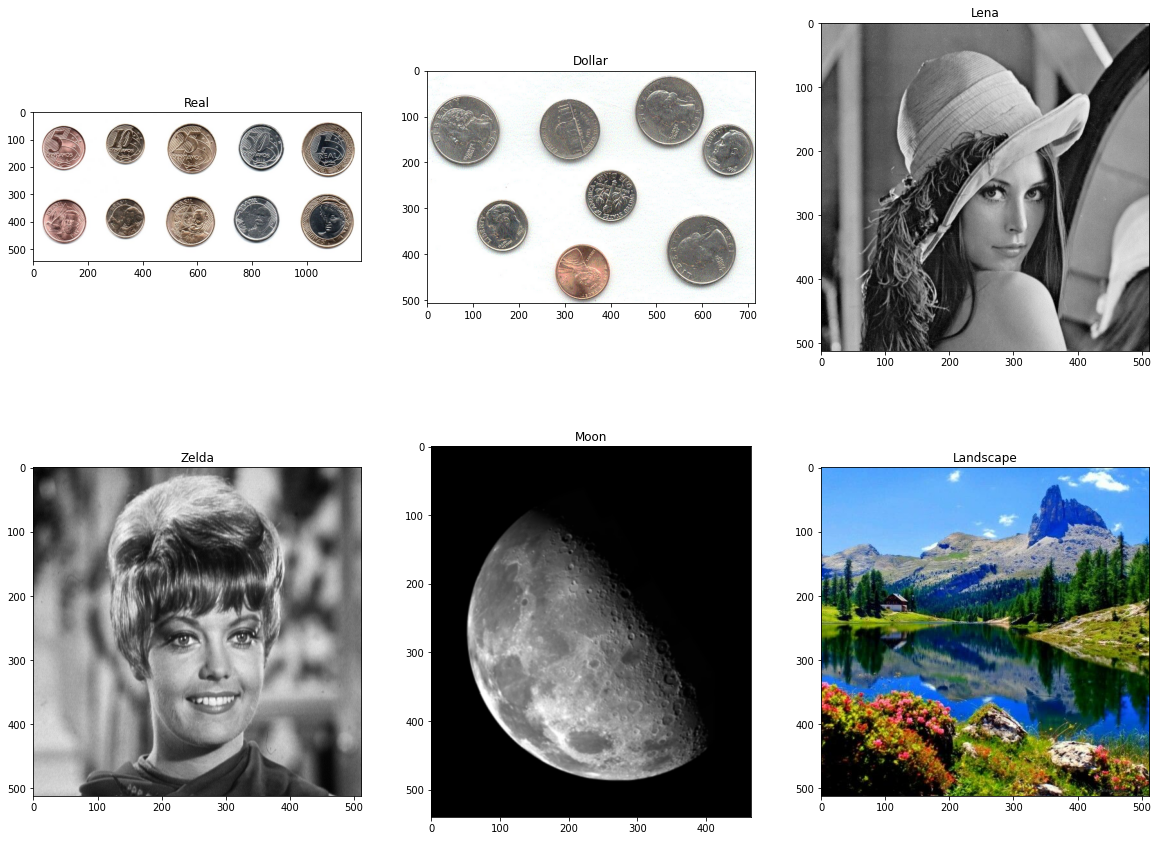

In [ ]:
real_gray = cv2.imread('moedas_real.jpg',0)
real = cv2.imread('moedas_real.jpg')
real = cv2.cvtColor(real, cv2.COLOR_BGR2RGB)

dollar_gray = cv2.imread('moedas.PNG',0)
dollar = cv2.imread('moedas.PNG')
dollar = cv2.cvtColor(dollar, cv2.COLOR_BGR2RGB)

lena = cv2.imread('lena.bmp',0)
zelda = cv2.imread('zelda.png',0)
moon = cv2.imread('Lua.tif',0)

landscape  = cv2.imread('paisagem.png')
landscape  = cv2.cvtColor(landscape, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 15), constrained_layout=False)
plt.subplot(231), plt.imshow(real), plt.title("Real")
plt.subplot(232), plt.imshow(dollar), plt.title("Dollar")
plt.subplot(233), plt.imshow(lena, cmap='gray'), plt.title("Lena")
plt.subplot(234), plt.imshow(zelda, cmap='gray'), plt.title("Zelda")
plt.subplot(235), plt.imshow(moon, cmap='gray'), plt.title("Moon")
plt.subplot(236), plt.imshow(landscape), plt.title("Landscape")


#Item 1

> Para este item, utilizei uma lógica parecido a que usei na lista 4, na qual utilizando a função [cv2.HoughCircles](https://docs.opencv.org/3.4/d3/de5/tutorial_js_houghcircles.html) para detectar as bordas das moedas. Primeiramente é feito uma abertura, detecta as bordas das moedas e se obtêm os seus centroides. Esse procedimento é feito na função *circles*.

(<matplotlib.image.AxesImage at 0x7f99a9e02450>, Text(0.5, 1.0, 'All circles'))

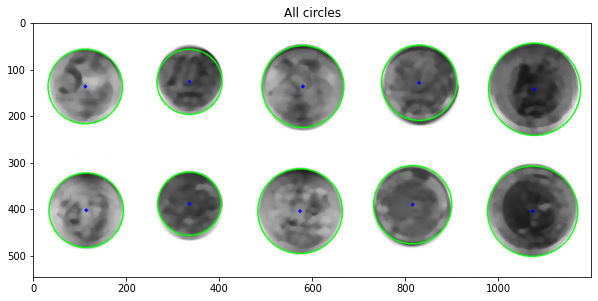

In [ ]:
[circles_real, real_vector] = circles(real_gray, 9, 75)
plt.figure(figsize=(10, 10))
plt.imshow(circles_real), plt.title('All circles')

> Sabendo a posição dos centroides, é possível determinar um *range* pela posição das moedas na imagem.

In [ ]:
print(real_vector)

[[[ 574  404   91]
  [1074  404   97]
  [ 112  136   80]
  [ 114  402   80]
  [ 336  388   68]
  [ 580  136   88]
  [1078  142   99]
  [ 816  390   84]
  [ 830  128   81]
  [ 336  126   70]]]


In [ ]:
five_cents = 0
ten_cents = 0
twenty_five_cents = 0
fifty_cents = 0
one_real = 0
for x,y,r in real_vector[0,:]:
  if x < 200:
    five_cents += 1
  elif x >=200 and x < 400:
    ten_cents += 1
  elif x >= 400 and x < 600:
    twenty_five_cents += 1
  elif x >= 600 and x <880:
    fifty_cents += 1
  else:
    one_real += 1
value = 0.05*five_cents + 0.1*ten_cents + 0.25*twenty_five_cents + 0.5*fifty_cents + one_real
print('R$ {:.2f}'.format(value))

R$ 3.80


> Já para as moedas em dólares, é determinado o valor de acordo com o raio de cada círculo obtido na borda, sabendo que as moedas americanas por ordem de tamanho são:
- quarter (25c)
- nickel (5c )
- penny (1c)
- dime (10c)

(<matplotlib.image.AxesImage at 0x7f99a9df3510>, Text(0.5, 1.0, 'All circles'))

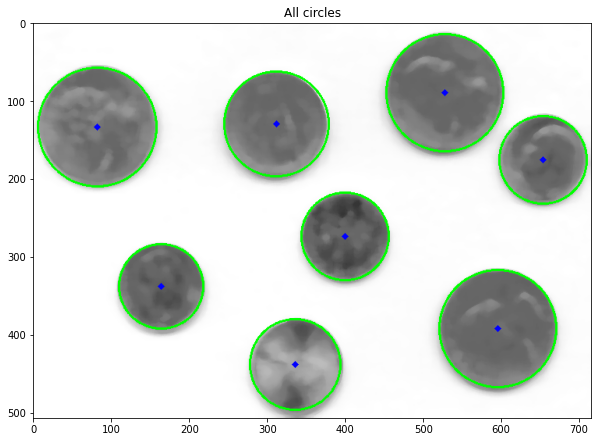

In [ ]:
[circles_dollar, dollar_vector] = circles(dollar_gray,7,50)
plt.figure(figsize=(10, 10))
plt.imshow(circles_dollar), plt.title('All circles')

In [ ]:
print(dollar_vector)

[[[596 392  75]
  [ 82 134  76]
  [528  90  75]
  [400 274  56]
  [164 338  54]
  [336 438  58]
  [312 130  67]
  [654 176  56]]]


In [ ]:
penny = 0
nickel = 0
dime = 0
quarter = 0
for x,y,r in dollar_vector[0,:]:
  if r <= 57:
    dime += 1
  elif r >57 and r < 61:
    nickel += 1
  elif r >= 61 and r < 68:
    penny += 1
  else:
    quarter += 1
value = 0.01*penny + 0.05*nickel + 0.1*dime + 0.25*quarter
print('US$ {:.2f}'.format(value))

US$ 1.11


>> Foi utilizada uma lógica simples, e por isso só funciona para as imagens em questão.

#Item 2

##Item 2.1 a 2.5

> Primeiramente a imagem selecionada foi a da *Lena*. A função *jpeg_implementation* executa o passo a passo para a compressão. Primeiramente deve ser informado a imagem e o valor de qualidade $qual$, onde ($0 <qual \leq 100$), se a qualidade for 50, a matriz de quantização é igual a matriz do item 1.3:

$$ \small
            Q = \left[ \begin{array}{llllllll}
                 16&11&10&16&24&40&51&61\\
                 12&12&14&19&26&58&60&55\\
                 14&13&16&24&40&57&69&56\\
                 14&17&22&29&51&87&80&62\\
                18&22&37&56&68&109&103&77\\
                24&35&55&64&81&104&113&92\\
                49&64&78&87&103&121&120&101\\
                72&92&95&98&112&100&103&99
              \end{array} \right].
$$
> Se não ela é corrida pelo valor de escala:

$$ \small
\text{escala}_{q} = 
\begin{cases}
    \frac{50}{\text{qual}},& \text{se } \text{qual} \geq 50\\
    2 - \frac{\text{qual}\cdot 2}{100},              & \text{caso contrário}.
\end{cases}
$$

> Essa função retorna o passo a passo da compressão, sendo a imagem após a transformação usando a DCT-2D, a imagem após a quantização, a imagem após dequantizar e a imagem restaurada após a IDCT-2D. Em cada passo, há a realização de arredondamento dos valores do *pixels*, por isso é uma compressão com perdas.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99a9d26890>,
 Text(0.5, 1.0, 'Reconstruction'))

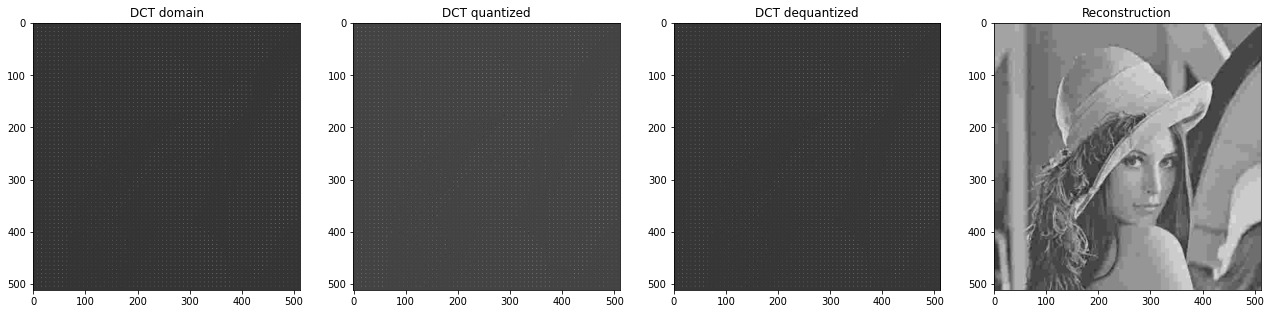

In [ ]:
[dct_domain, dct_quantized, dct_dequantized, dct_restored] = jpeg_implementation(lena, 50)
plt.figure(figsize=(22, 22), constrained_layout=False)
plt.subplot(141),plt.imshow(dct_domain, cmap='gray', vmin= dct_domain.min(), vmax=dct_domain.max()), plt.title('DCT domain')
plt.subplot(142),plt.imshow(dct_quantized, cmap='gray', vmin= dct_quantized.min(), vmax=dct_quantized.max()), plt.title('DCT quantized')
plt.subplot(143),plt.imshow(dct_dequantized, cmap='gray', vmin= dct_dequantized.min(), vmax=dct_dequantized.max()), plt.title('DCT dequantized')
plt.subplot(144),plt.imshow(dct_restored, cmap='gray', vmin= dct_restored.min(), vmax=dct_restored.max()), plt.title('Reconstruction')

## Item 2.4 e 2.6

> A função *entropy*, que recebe somente uma imagem e a partir do histograma da imagem, calcula a entropia.

> A função *metrics* determina as métricas de qualidade PNSR, MSE e SSIM, as entradas são a imagem de referência e a imagem restaurada, no caso a imagem original da Lena e a restaurada pela função *jpeg_implementation*.

In [ ]:
[pnsr, mse, ssim_const] = metrics(lena, dct_restored)
H = entropy(lena)
H_quant = entropy(dct_quantized)
print('PNSR = {:.2f}'.format(pnsr))
print('MSE = {:.2f}'.format(mse))
print('SSIM = {:.2f}'.format(ssim_const))
print('The entropy in original image is {:.4f}'.format(H))
print('The entropy in quantized image is {:.4f}'.format(H_quant))

PNSR = 28.12
MSE = 100.26
SSIM = 0.77
The entropy in original image is 0.4524
The entropy in quantized image is 0.0008


>> De acordo com a teoria da informação, a entropia tem relação com o nível de desordem e de redundância das imagens, e quanto maior a entropia maior essas grandezas. Logo, o fato da entropia da imagem quantizada ser 565,5 vezes menor do que a imagem original, mostra q ele reduziu a redundância da imagem da Lena.

##Item 2.7

> os passos 2.1 a 2.5 foram feitos novamente nas imagens da Zelda, Paisagem e da Lua, sendo a da paisagem colorida só a título de curiosidade.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99a9bba950>,
 Text(0.5, 1.0, 'Reconstruction'))

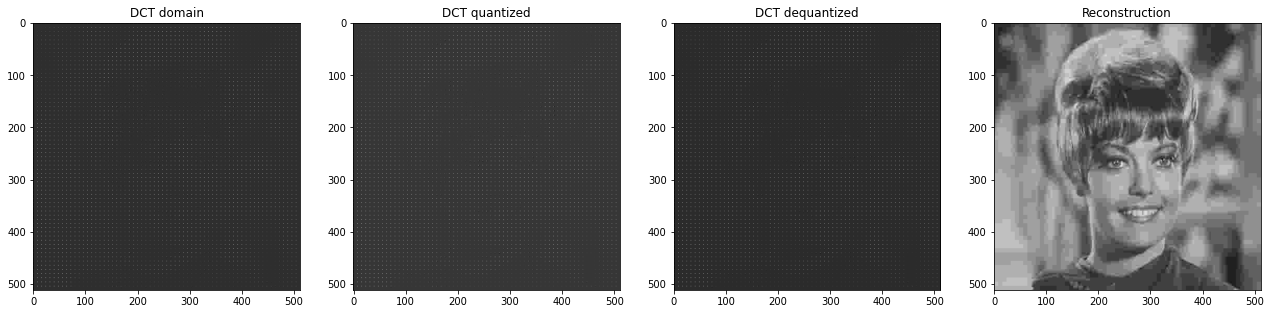

In [ ]:
[dct_domain_z, dct_quantized_z, dct_dequantized_z, dct_restored_z] = jpeg_implementation(zelda, 50)
plt.figure(figsize=(22, 22), constrained_layout=False)
plt.subplot(141),plt.imshow(dct_domain_z, cmap='gray', vmin= dct_domain_z.min(), vmax=dct_domain_z.max()), plt.title('DCT domain')
plt.subplot(142),plt.imshow(dct_quantized_z, cmap='gray', vmin= dct_quantized_z.min(), vmax=dct_quantized_z.max()), plt.title('DCT quantized')
plt.subplot(143),plt.imshow(dct_dequantized_z, cmap='gray', vmin= dct_dequantized_z.min(), vmax=dct_dequantized_z.max()), plt.title('DCT dequantized')
plt.subplot(144),plt.imshow(dct_restored_z, cmap='gray', vmin= dct_restored_z.min(), vmax=dct_restored_z.max()), plt.title('Reconstruction')

In [ ]:
[pnsr_z, mse_z, ssim_const_z] = metrics(zelda, dct_restored_z)
print('PNSR = {:.2f}'.format(pnsr_z))
print('MSE = {:.2f}'.format(mse_z))
print('SSIM = {:.2f}'.format(ssim_const_z))

PNSR = 29.74
MSE = 68.96
SSIM = 0.75


Fiz com uma imagem colorida só para saber o resultado.


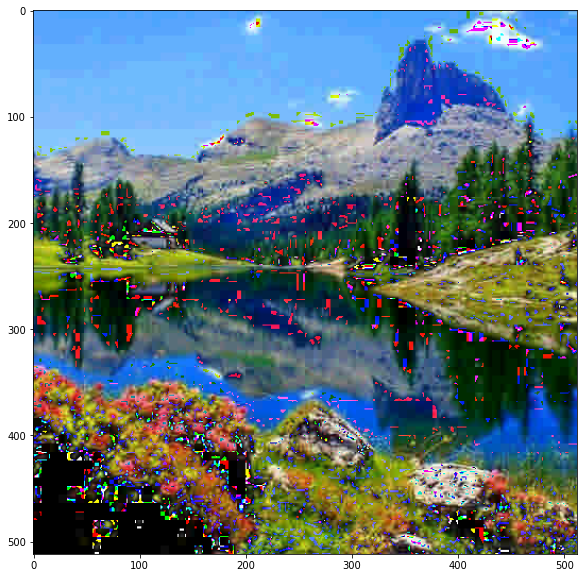

In [ ]:
result = np.zeros((landscape.shape), dtype = np.uint8)
for i in range(landscape.shape[2]):
  [dct_domain, dct_quantized, dct_dequantized, dct_restored] = jpeg_implementation(landscape[:,:,i], 70)
  result[:,:,i]=dct_restored
plt.figure(figsize=(10, 10), constrained_layout=False)
plt.imshow(result)

> Diferente das outras imagens, a imagem da Lua não é quadrada, e mesmo assim, os índices de qualidade, principalmente o SSIM são altos.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99a99b34d0>,
 Text(0.5, 1.0, 'Reconstruction'))

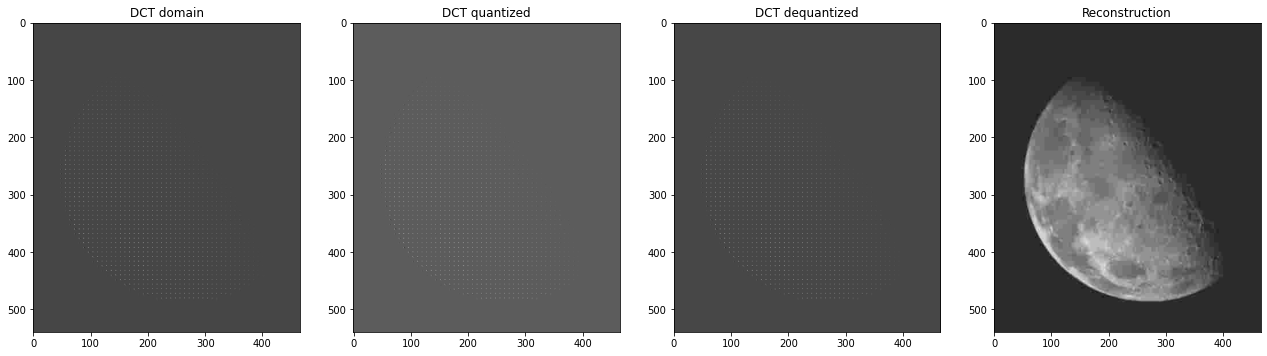

In [ ]:
[dct_domain_m, dct_quantized_m, dct_dequantized_m, dct_restored_m] = jpeg_implementation(moon, 50)
plt.figure(figsize=(22, 22), constrained_layout=False)
plt.subplot(141),plt.imshow(dct_domain_m, cmap='gray', vmin= dct_domain_m.min(), vmax=dct_domain_m.max()), plt.title('DCT domain')
plt.subplot(142),plt.imshow(dct_quantized_m, cmap='gray', vmin= dct_quantized_m.min(), vmax=dct_quantized_m.max()), plt.title('DCT quantized')
plt.subplot(143),plt.imshow(dct_dequantized_m, cmap='gray', vmin= dct_dequantized_m.min(), vmax=dct_dequantized_m.max()), plt.title('DCT dequantized')
plt.subplot(144),plt.imshow(dct_restored_m, cmap='gray', vmin= dct_restored_m.min(), vmax=dct_restored_m.max()), plt.title('Reconstruction')

In [ ]:
[pnsr_m, mse_m, ssim_const_m] = metrics(moon, dct_restored_m)
print('PNSR = {:.2f}'.format(pnsr_m))
print('MSE = {:.2f}'.format(mse_m))
print('SSIM = {:.2f}'.format(ssim_const_m))

PNSR = 32.29
MSE = 38.36
SSIM = 0.90


> Para os 10 níveis de qualidade foi-se utilizada novamente a imagem da Lena, aumentando de 5 em 5.

In [ ]:
results55 = jpeg_implementation(lena, 55)
results60 = jpeg_implementation(lena, 60)
results65 = jpeg_implementation(lena, 65)
results70 = jpeg_implementation(lena, 70)
results75 = jpeg_implementation(lena, 75)
results80 = jpeg_implementation(lena, 80)
results85 = jpeg_implementation(lena, 85)
results90 = jpeg_implementation(lena, 90)
results95 = jpeg_implementation(lena, 95)
results100 = jpeg_implementation(lena, 100)

met_quality55 = metrics(lena, results55[3])
met_quality60 = metrics(lena, results60[3])
met_quality65 = metrics(lena, results65[3])
met_quality70 = metrics(lena, results70[3])
met_quality75 = metrics(lena, results75[3])
met_quality80 = metrics(lena, results80[3])
met_quality85 = metrics(lena, results85[3])
met_quality90 = metrics(lena, results90[3])
met_quality95 = metrics(lena, results95[3])
met_quality100 = metrics(lena, results100[3])


((49.5, 101.0), (0.7593463358508137, 0.8233874848998783))

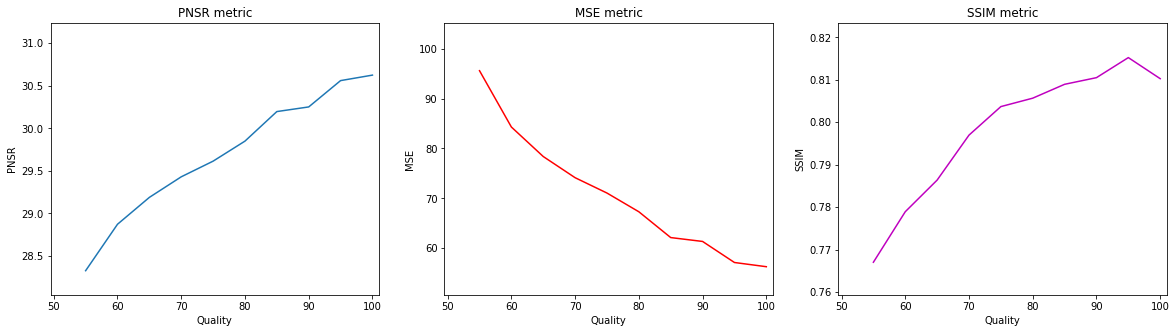

In [ ]:
x = np.array([55,60,65,70,75,80,85,90,95,100])
y_pnsr = np.array([met_quality55[0], met_quality60[0], met_quality65[0], met_quality70[0],
                   met_quality75[0], met_quality80[0], met_quality85[0], met_quality90[0],
                   met_quality95[0], met_quality100[0]])
y_mse = np.array([met_quality55[1], met_quality60[1], met_quality65[1], met_quality70[1],
                   met_quality75[1], met_quality80[1], met_quality85[1], met_quality90[1],
                   met_quality95[1], met_quality100[1]])
y_ssim = np.array([met_quality55[2], met_quality60[2], met_quality65[2], met_quality70[2],
                   met_quality75[2], met_quality80[2], met_quality85[2], met_quality90[2],
                   met_quality95[2], met_quality100[2]])
plt.figure(figsize=(20, 5), constrained_layout=False)
plt.subplot(131),plt.plot(x,y_pnsr), plt.title('PNSR metric'), plt.xlabel('Quality'), plt.ylabel('PNSR')
plt.xlim(x.min()-0.1*x.min(), x.max()+ 0.01*x.max()),plt.ylim(y_pnsr.min()-0.01*y_pnsr.min(), y_pnsr.max()+ 0.02*y_pnsr.max())
plt.subplot(132),plt.plot(x,y_mse, 'r'), plt.title('MSE metric'), plt.xlabel('Quality'), plt.ylabel('MSE')
plt.xlim(x.min()-0.1*x.min(), x.max()+ 0.01*x.max()),plt.ylim(y_mse.min()-0.1*y_mse.min(), y_mse.max()+ 0.1*y_mse.max())
plt.subplot(133),plt.plot(x,y_ssim, 'm'), plt.title('SSIM metric'), plt.xlabel('Quality'), plt.ylabel('SSIM')
plt.xlim(x.min()-0.1*x.min(), x.max()+ 0.01*x.max()),plt.ylim(y_ssim.min()-0.01*y_ssim.min(), y_ssim.max()+ 0.01*y_ssim.max())

>> Como cada método é baseado em uma teoria diferente, os gráficos não podem ser comparados diretamente. No PSNR é uma relação sinal-ruído a partir da métrica do erro quadrático. Como o erro quadrático tende a ser uma função decrescente, pois quando melhor a reconstrução menor o erro associado, a função PNSR é crescente pois quanto menor o erro maior a relação sinal-ruído, ou seja, são funções com comportamento semelhante a inversamente proporcional.

>> Já a métrica SSIM ela avalia e prediz a qualidade pela estrutura da imagem, logo não há como comparar com o PNSR e o MSE.

#Item 3

## Item 3.1

In [ ]:
# O MNIST contém 70.000 imagens de resolução 28 x 28 pixels. sendo 60.000 reservadas para o treinamento e 10.000 para teste
# O índice X abaixo se refere às imagens de cada conjunto, enquanto que o y se refere ao rótulo (y)
 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


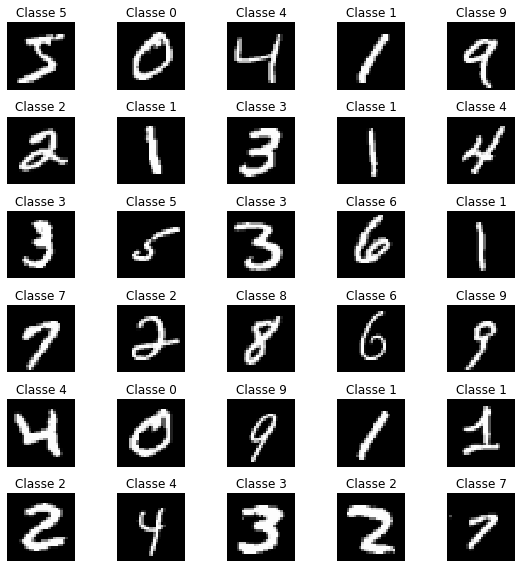

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['image.cmap'] = 'gray'

# %%
x = X_train[:30]
y = y_train[:30]

# %%
plt.figure()

for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.imshow(x[i], interpolation='none')
    plt.title("Classe {}".format(y[i]))
    plt.axis('off')

plt.show()


## Item 3.2

> Uma assinatura é uma representação 1-D de uma fronteira que pode ser gerada de várias maneiras.

> A assinatura $R(\theta)$ possui algumas maneiras descritas no livro para ser feito, na função *r_theta*, a distância é calculada a partir da maior distância do centroide, pressupondo a uniformidade na escala. A função *r_theta* tem como parâmetro a imagem retornando os ângulos e as distâncias.

> O descritor de Fourier, na função *fourier_descriptor*, a partir da fronteira digital dos pontos da imagem, associa cada ponto das coordenadas a um valor $s = x +jy$. Após essa mudança de variáveis, é realizado a transformada discreta de Fourier (DFT), sendo estes os descritores de Fourier. Porém supondo que somente os primeiros pontos P, a transformada é contida até P-1. A função *fourier_descriptor* tem como requisitos a imagem e esse valor P, retornando os descritores.

> O número de Euler, na função *EulerNumbers*, é um descritor topológico que a partir da fórmula de Euler, faz a conexão das regiões e determina quantos buracos tem uma uma região poligonal da imagem. Assim como na lista 4, utilizei essa função novamente. A função retorna o número de Euler, onde se:
 - $e=1$, não há buracos;
 - $e=0$, há 1 buraco;
 - $e<0$, há mais de um buraco.

In [ ]:
dists = []
angles = []
fourier = []
euler = []
for i in range(30):
  dists_, angles_ = r_theta(x[i])
  f = fourier_descriptor(x[i],20)
  e = EulerNumbers(x[i])
  if e.shape[0]>1:
    e = e[0]
  dists.append(dists_)
  angles.append(angles_)
  fourier.append(f)
  euler.append(e)

## Item 3.3

> Após implementar cada descritor, para os valores 1 e 5, foram plotados cada resultado de descritor.

### Assinatura $R(\theta)$

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99a8d3d810>,
 Text(0.5, 1.0, 'Classe 5'))

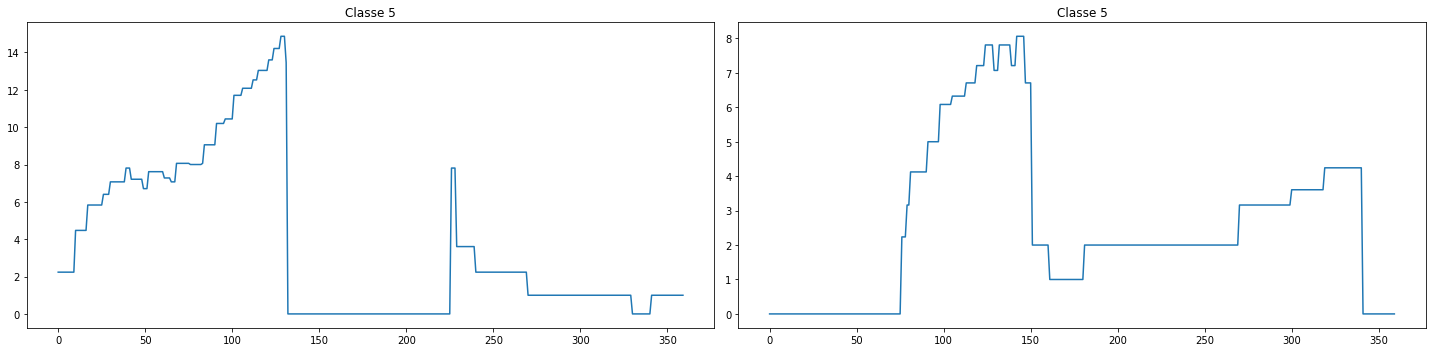

In [ ]:
plt.figure(figsize=(20, 5), constrained_layout=False)
plt.subplot(121),plt.plot(dists[0]), plt.title('Classe {}'.format(y[0]))
plt.subplot(122),plt.plot(dists[11]), plt.title('Classe {}'.format(y[11]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99a0270ad0>,
 Text(0.5, 1.0, 'Classe 1'))

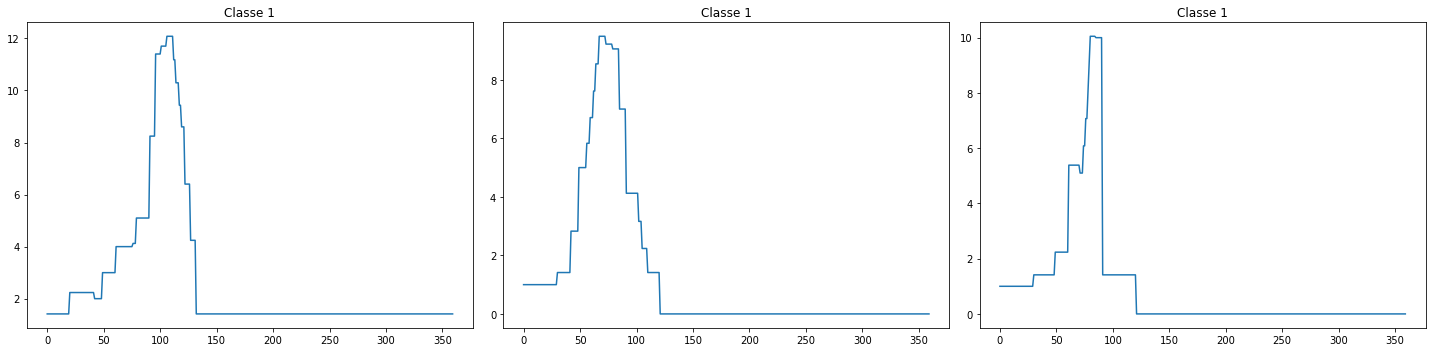

In [ ]:
plt.figure(figsize=(20, 5), constrained_layout=False)
plt.subplot(131),plt.plot(dists[3]), plt.title('Classe {}'.format(y[3]))
plt.subplot(132),plt.plot(dists[6]), plt.title('Classe {}'.format(y[6]))
plt.subplot(133),plt.plot(dists[8]), plt.title('Classe {}'.format(y[8]))

### Fourier

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99a024fd10>,
 Text(0.5, 1.0, 'Classe 5'))

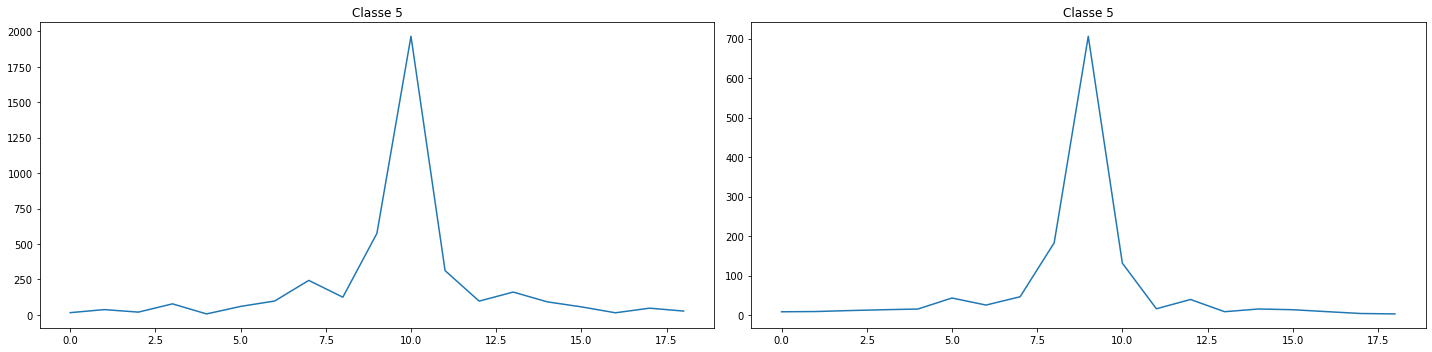

In [ ]:
plt.figure(figsize=(20, 5), constrained_layout=False)
plt.subplot(121),plt.plot(np.abs(fourier[0])), plt.title('Classe {}'.format(y[0]))
plt.subplot(122),plt.plot(np.abs(fourier[11])), plt.title('Classe {}'.format(y[11]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99a007ee90>,
 Text(0.5, 1.0, 'Classe 1'))

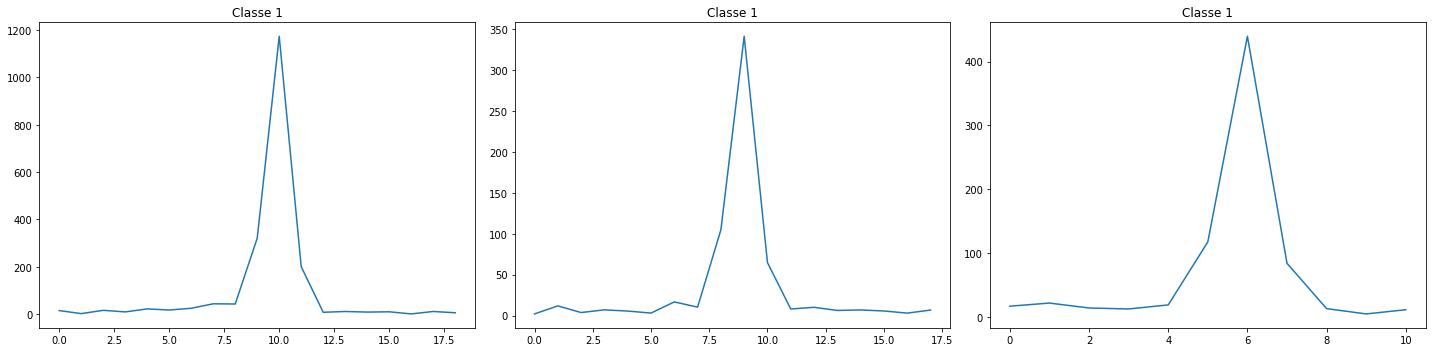

In [ ]:
plt.figure(figsize=(20, 5), constrained_layout=False)
plt.subplot(131),plt.plot(np.abs(fourier[3])), plt.title('Classe {}'.format(y[3]))
plt.subplot(132),plt.plot(np.abs(fourier[6])), plt.title('Classe {}'.format(y[6]))
plt.subplot(133),plt.plot(np.abs(fourier[8])), plt.title('Classe {}'.format(y[8]))

### Número de Euler

In [ ]:
print('The euler number to classe {} is {}.'.format(y[0],euler[0]))
print('The euler number to classe {} is {}.'.format(y[11],euler[11]))

The euler number to classe 5 is [1].
The euler number to classe 5 is [1].


In [ ]:
print('The euler number to classe {} is {}.'.format(y[3],euler[3]))
print('The euler number to classe {} is {}.'.format(y[6],euler[6]))
print('The euler number to classe {} is {}.'.format(y[8],euler[6]))

The euler number to classe 1 is [1].
The euler number to classe 1 is [1].
The euler number to classe 1 is [1].


>> Pelos resultados mostrados, cada um mostra certa similaridade para cada algorismo igual, porém, como no número de Euler, que tem o mesmo valor para algorismos diferentes, não é possível determinar se os descritores classificam os algorismos.

## Item 3.4

> O classificador de Bayes é um classificador estatístico ótimo que usa uma abordagem probabilística para o reconhecimento.

> A partir da equação de risco médio condicional, se determina a probabilidade de um padrão **x** pertencer a uma classe dado uma perda. O classificador bayesiano é aquele que minimiza a perda média total do padrão **x**, assim atribuindo o vetor de caracteríticas **x** a uma classe cuja a equação de decisão seja a maior probabilidade de pertencer a classe.

> Para um classificador bayesiano para classes gaussianas, a equação de decisão é definida a partir do vetor médio e a matriz de covariância do valor esperado do argumento sobre os padrões.

In [ ]:
import numpy as np
from time import time
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix

'''
    From Ibrahim Odumas Odufowora
    Project Name: Classification with MNIST

    Adapted from:
    https://github.com/ibodumas/naivebayes_mnist/blob/master/Classification_MNIST_NaiveBayes.ipynb
    Accessed on 21.05.2020.
    '''

class Utility:
    """This class warehouses the data and other general functions"""
    def __init__(self):
        self.train = np.asarray([np.reshape(x, (784)) for x in X_train]).astype('float64') #change train_image to numpy array #784 means 28 by 28 pixel
        self.train_label = np.asarray(y_train)
        self.test = np.asarray([np.reshape(x, (784)) for x in X_test]).astype('float64') #change test_image to numpy array
        self.test_label = np.asarray(y_test)
        self.n_class = list(range(10)) #class labels
        
    def confusionMatrix(self, actual, predict, print_cfm=True, print_err_digit=True):
        cfm = pd.DataFrame(confusion_matrix(actual, predict))
        err_all = round((1 - sum(np.diagonal(cfm)) / len(predict)) * 100, 4)
        error_digit = []
        for i in self.n_class:
            error_digit.append(round(1 - cfm.iloc[i,i] / sum(cfm.iloc[i,:]), 4) * 100)

        tab_error = pd.DataFrame(columns=['digit', 'error per digit in %'])
        tab_error['digit'] = self.n_class
        tab_error['error per digit in %'] = error_digit

        if print_cfm:
            print('Testing Confusion Matrix: Actual vs. Prediction')
            display(cfm)

        if print_err_digit:
            print('% error per digit')
            display(tab_error)
            print('\nThe overall testing error is {}%'.format(err_all))

        return cfm, tab_error, err_all
    def nFoldCV_NB(self, train, train_label, smoothings, kFolds):
        stra_all = self.folds_stratify(nSample=len(train), kFolds=kFolds)
        ave_test_err = []
        for s, sVal in enumerate(smoothings):
            test_err = []
            for k in range(kFolds):
                stra = stra_all.copy()
                te = train[stra[k]]
                te_lb = train_label[stra[k]]
                del stra[k]  # del test list
                tr = train[list(chain.from_iterable(stra))]
                tr_lb = train_label[list(chain.from_iterable(stra))]
                nb = NaiveBayes(train=tr, train_lb=tr_lb, test=te, test_lb=te_lb, smoothing=sVal)
                nb.predict()
                conf = self.confusionMatrix(te_lb, nb.pred, False, False)
                test_err.append(conf[2])

            ave_test_err.append(np.mean(test_err))

        return ave_test_err
    def folds_stratify(self, nSample, kFolds):
        """This return kfold stratification"""
        foldSize = round(nSample / kFolds, 0)
        randomList = list(range(0, nSample))
        random.shuffle(randomList)
        stratify = []

        for k in range(0, kFolds):
            strt = int(k * foldSize)
            end = int((k + 1) * foldSize)
            if k == (kFolds - 1):
                end = nSample
            stratify.append(list(randomList)[strt:end])

        return stratify
    
    def CV_plot(k_error, k_list, title):
        k_error = np.round(k_error, 4)
        best_k = k_list[np.argmin(k_error)]
        err_best_k = np.min(k_error)
        plt.plot(k_list, k_error, '-gD', color='black')
        ax = plt.subplot(111)
        ax.set_xticks(k_list, k_list)
        plt.ylabel('% Error')
        plt.xlabel(title)
        plt.title('Plot of ' + title + ' vs. average 5 foldCV error')
        plt.show()
        print('The best value of ' + title + ' is {} with an error of {}%'.format(best_k, err_best_k))
        print('\n' + title + ' = {} will be used to model the entire training set and prediction on testing set:'.format(best_k))
        return best_k, err_best_k
    def images_plot(imageData):
        classes = ["P(x|c=0)", "P(x|c=1)", "P(x|c=2)", "P(x|c=3)", "P(x|c=4)", "P(x|c=5)", "P(x|c=6)", "P(x|c=7)",
                   "P(x|c=8)", "P(x|c=9)"]

        num_classes = len(classes)
        plt.subplots(figsize=(15, 2))
        for y, cls in enumerate(classes):
            plt_idx = y + 1
            plt.subplot(1, num_classes, plt_idx)
            if prob:
                plt.imshow(imageData[y].reshape((28, 28)))
            else:
                plt.imshow(imageData[y].reshape(785, 1)[1:785].reshape((28, 28)))
            plt.axis("off")
            plt.title(cls)

        plt.tight_layout()
        plt.show()

class NaiveBayes:
    """This class warehouses the Naive bayes classifier"""
    def __init__(self, train, train_lb, test, test_lb, smoothing, jupyter=True, plot_dis=False):
        self.n_class = np.unique(train_lb)
        self.tr = train
        self.te = test
        self.tr_lb = train_lb
        self.te_lb = test_lb
        self.plot_dis = plot_dis
        self.jupyter = jupyter
        self.smoothing = smoothing
        #if jupyter:
            #self.plotly = iplot
        #else:
            #self.plotly = plot

    def mean_std_prior(self):
        """Mean and Std per feature per class, and prior per class"""
        self.mean, self.std, self.priors, self.count = [], [], [], []
        for i, val in enumerate(self.n_class):
            sep = [self.tr_lb == val] #separated
            self.count.append(len(self.tr_lb[sep]))
            self.priors.append(len(self.tr_lb[sep]) / len(self.tr_lb))
            self.mean.append(np.mean(self.tr[sep], axis=0))
            self.std.append(np.std(self.tr[sep], axis=0))

        if self.plot_dis:
            bar_data = Bar(x=list(range(len(self.count))), y=self.count)
            data_plt = Data([bar_data])
            layout = Layout(yaxis=YAxis(title='counts'), xaxis=XAxis(title='classes', dtick=1),
                            title='Class distribution in Train set')
            fig = Figure(data=data_plt, layout=layout)
            self.plotly(fig)
    def predict(self):
        """prediction: by summing the natural log of all the conditional probability given the class."""
        str_time = time()
        self.mean_std_prior()
        self.pred = []
        self.likelihood = []
        self.logsum_chk = []
        for n in range(len(self.te_lb)):
            classifier = []
            sample = self.te[n] #test sample
            likelih = []
            for i, val in enumerate(self.n_class):
                mean = self.mean[i]
                var = np.square(self.std[i]) + self.smoothing
                prob = 1 / np.sqrt(2 * np.pi * var) * np.exp(-np.square(sample - mean)/(2 * var))
                result = np.sum(np.log(prob)) #, np.log(self.priors[i])) #not needed, we assume equal prior
                classifier.append(result)
                likelih.append(prob)

            self.pred.append(np.argmax(classifier))
            self.likelihood.append(likelih)
            self.logsum_chk.append(classifier)
        self.end_time = time() - str_time

#End of Class Naive Bayes

In [ ]:
util = Utility()
smoothings_nb = list(range(500, 2100, 100))
kfold_nb = util.nFoldCV_NB(util.train, util.train_label, smoothings_nb, kFolds=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diff

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


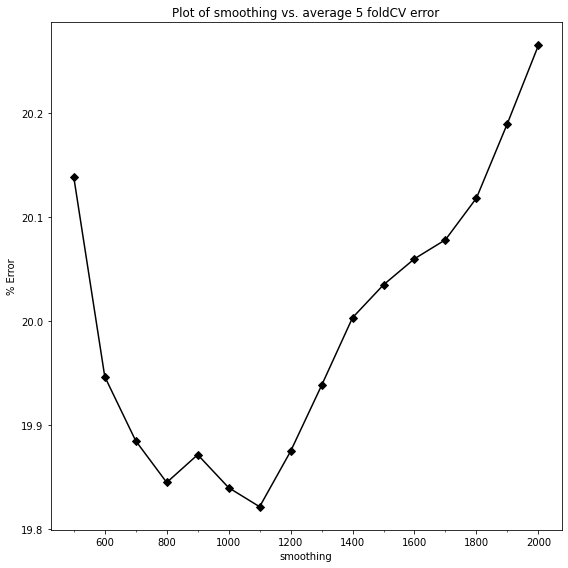

The best value of smoothing is 1100 with an error of 19.8217%

smoothing = 1100 will be used to model the entire training set and prediction on testing set:


In [ ]:
sm_plot = Utility.CV_plot(kfold_nb, smoothings_nb, 'smoothing')

## Item 3.5

> A clasificação de predição do algoritmo é apresentada nas tabelas a seguir, onde a primeira tabela mostra o valor atual e a predição do algoritmo e a segunda o erro associado a cada algorismo.

In [ ]:
util = Utility()
best_s = smoothings_nb[np.argmin(kfold_nb)]
nb = NaiveBayes(train=util.train, train_lb=util.train_label, test=util.test, test_lb=util.test_label, smoothing=best_s)
nb.predict()
conf_matix = util.confusionMatrix(util.test_label, nb.pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diff

Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,899,0,0,4,1,15,21,1,35,4
1,0,1096,1,4,0,0,6,0,28,0
2,15,39,776,31,9,5,57,15,80,5
3,6,37,26,813,0,18,14,11,42,43
4,4,6,4,0,641,4,22,1,19,281
5,20,28,7,94,22,573,23,11,64,50
6,12,22,10,1,9,22,868,0,13,1
7,1,38,8,4,21,0,1,839,26,90
8,7,67,8,38,11,17,12,4,742,68
9,6,18,3,9,38,2,0,15,18,900


% error per digit


,digit,error per digit in %
0,0,8.27
1,1,3.44
2,2,24.81
3,3,19.50
4,4,34.73
5,5,35.76
6,6,9.39
7,7,18.39
8,8,23.82
9,9,10.80



The overall testing error is 18.53%
